# Camera Calibration Parameters

The goal of this cell is to demonstrate how to use the camera calibration pamameters.

## Disclaimer

This notebook assumes a basic understanding of perspective projection as described in the OpenCV tutorial.

- [Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)

That is, we assume that you know the perspective projection without lens distortion is given by

$$ \lambda \tilde{\bm{x}} = K \begin{bmatrix} R & \bm{t} \end{bmatrix} \tilde{\bm{X}} \,,$$

where $\tilde{\bm{X}}$ and $\tilde{\bm{x}}$ are a 3D point in the world coodinate system and its projection in the image, both expressed in homogeneous coordinates, $R, \bm{t}$ is the extrinsic parameters ($3 \times 3$ rotation matrix and $3 \times 1$ translation vector), $K$ is the intrinsic parameter, and $\lambda$ is the scaling factor corresponding to the depth, i.e, the distance from the camera center to $\bm{X}$.

The defining $P = K \begin{bmatrix} R & \bm{t} \end{bmatrix}$, we can rewrite this as

$$ \lambda \tilde{\bm{x}} = P \tilde{\bm{X}} \,,$$

where $P$ is a $3 \times 4$ *projection matrix*.

In some textbooks, the intrinsic parameter $K$ is denoted as $A$, the scaling factor $\lambda$ is denoted as $s$ or omitted by using $\sim$ (is equal up to scale) instead of $=$.


## Libraries

In [1]:
%matplotlib widget

import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

from pycalib.plot import plotCamera
from pycalib.calib import lookat

## Synthetic data

This cell defines a set of calibration parameters that satisfy

- world-to-camera: $c_i = R_i X + t_i$, and
- camera-to-image: $\lambda \tilde{x}_i = K_i c_i$,

where $X$ is a 3D point in the world coodinate system, and $i = 1,2$.

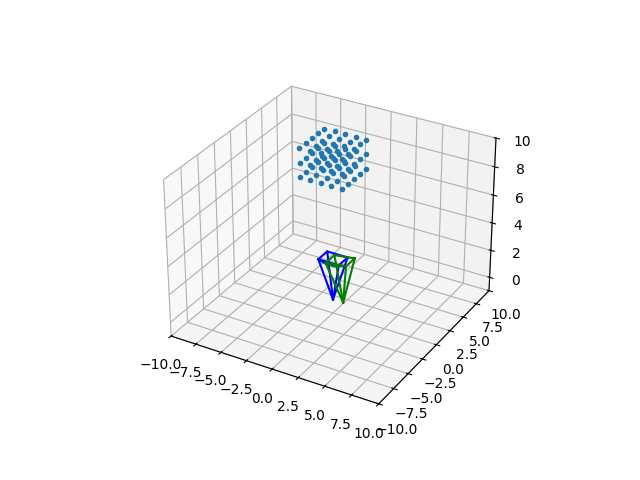

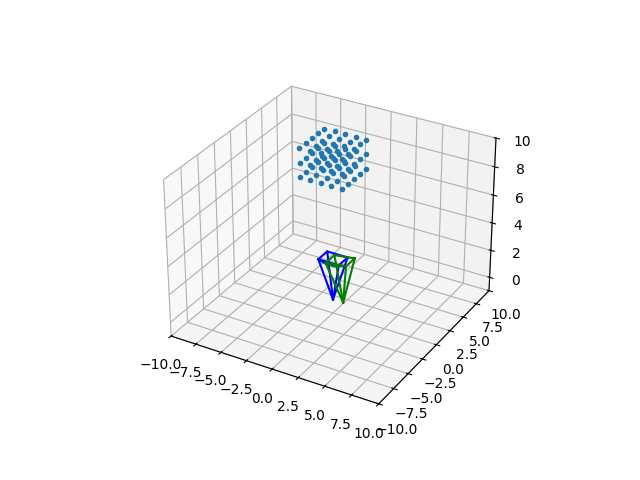

In [2]:
# 3D points
# X_gt = (np.random.rand(16, 3) - 0.5)*5 + [0, 0, 10] # random points centered at [0, 0, 10]
X_gt = np.array(np.meshgrid(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5), np.linspace(9, 11, 3))).reshape((3, -1)).T  # 3D grid points

# Camera poses
R1_gt = np.eye(3)
t1_gt = np.zeros(3).reshape((3,1))
R2_gt, t2_gt = lookat(np.array([1,0,0]), np.array([0,0,10]), np.array([0,1,0]))
rvec1_gt = cv2.Rodrigues(R1_gt)[0]
rvec2_gt = cv2.Rodrigues(R2_gt)[0]

# Camera intrinsics
K1 = np.array([[600, 0, 320], [0, 600, 240], [0, 0, 1]]).astype(np.float64)  # VGA camera
K2 = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]]).astype(np.float64)  # 720p camera

# 2D corresponding points
x1 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1, None)[0].reshape((-1, 2))
x2 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2, None)[0].reshape((-1, 2))

# Verify triangulation
Y = cv2.triangulatePoints(K1 @ np.hstack((R1_gt, t1_gt)), K2 @ np.hstack((R2_gt, t2_gt)), x1.T, x2.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)

# Verify z > 0 at each camera
assert np.all(X_gt[:, 2] > 0)
assert np.all((R2_gt @ X_gt.T + t2_gt)[2, :] > 0)

# plot the camera
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-1, 10)
plotCamera(ax, R1_gt, t1_gt, color="b", scale=1, is_w2c=True)
plotCamera(ax, R2_gt, t2_gt, color="g", scale=1, is_w2c=True)
ax.plot(X_gt[:,0], X_gt[:,1], X_gt[:,2], ".")
fig.show()

#

## Where is the camera in WCS?

Given the extrinsic parameters $R, t$ satisfying

$$ \lambda \tilde{\bm{x}} = K \begin{bmatrix} R & \bm{t} \end{bmatrix} \tilde{\bm{X}} \,,$$

how can we plot the camera in WCS?  In other words, where is the camera center, and what are the directions of each axis?  The short answer is

- The directions of $x$-, $y$-, and $z$-axes in WCS are the 1st, 2nd, and 3rd rows of $R$, and
- The camera center in WCS is located at $-R^\top \bm{t}$.

### Step-by-Step Derivation

The above projection equation includes the transformation from WCS to CCS (camera coordinate system) as

$$ \tilde{\bm{X}}_c = \begin{bmatrix} R & \bm{t} \end{bmatrix} \tilde{\bm{X}} \Leftrightarrow \bm{X}_c = R \bm{X} + \bm{t} \,,$$

where $\bm{X}_c$ is the 3D position of $\bm{X}$ in CCS.  From this expression, it is clear that each row of $R$ acts as the direction of the corresponding camera axis expressed in WCS because each coordinate of $\bm{X}_c$ is obtained as the inner-product between each row of $R$ and $\bm{X}$.  Similarly the camera center in WCS is the point that is mapped to $(0,0,0)^\top$ in CCS, namely, $-R^\top \bm{t}$.  If this is not immedinately obvious, we can understand it as follows.

Since the camera center is $(0,0,0)^\top$ in CCS, we have

$$ {X}_c = \bm{0} = R \bm{X}_o + \bm{t}\,, \quad \bm{X_o} = -R^\top \bm{t} \,,$$

which gives its position in WCS.

Next, consider the 3D point $(1,0,0)^\top$ in CCS.  Its 3D coordinates in WCS is $R^\top((1,0,0)^\top - \bm{t})$.  The direction of the $x$-axis in WCS is therefore $\bm{e}_x = R^\top((1,0,0)^\top - \bm{t}) - \bm{X}_o = R^\top (1,0,0)^\top$.  That is, the $x$-axis corresponds to the 1st row of $R$.  Similarly, the $y$- and $z$- axes correspond to the 2nd and the 3rd rows of $R$ respectively.


Alternatively, if the extrinsic parameters are given in the camera-to-world form (rather than world-to-camera), i.e., if we have

$$ \bm{X} = R' \bm{X}_c + \bm{t}' \,,$$

then the camera axes are given by the column vectors of $R'$ and the center is simply $\bm{t}'$.

Some textbooks and implemtations (e.g., Hartley and Zisserman) adopt yet another definition, emphasizing the interpretation of the rotation as

$$ \bm{X}_c = R'' (\bm{X} - \bm{t}'') \,,$$

in which case the axis directions are given by the row vectors of $R''$ and the center is $\bm{t}''$.



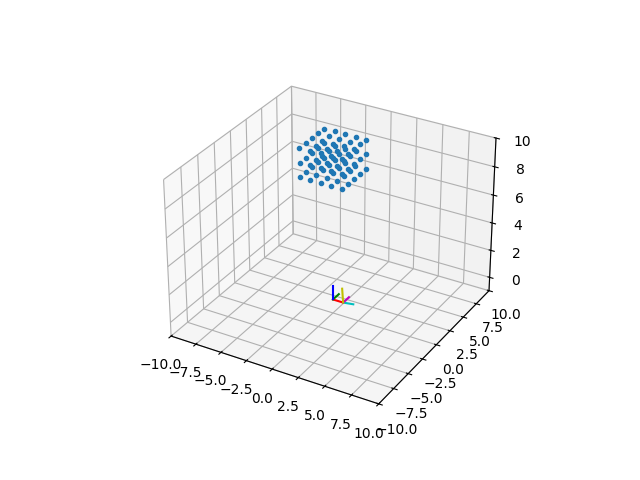

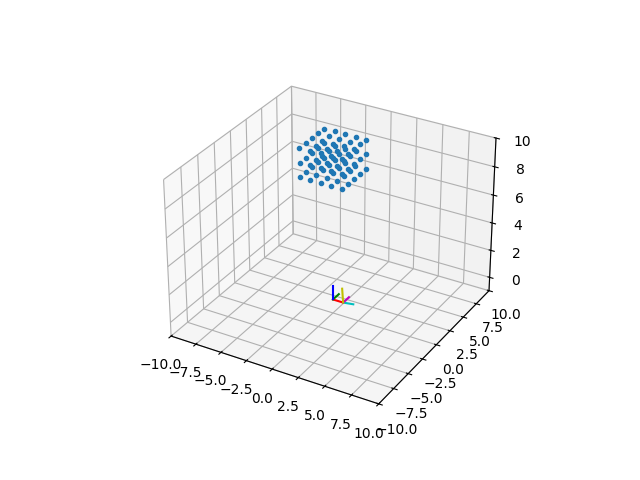

In [3]:
# plot the camera

def c2w(R, t, p):
    p = p.reshape((3,1))
    t = t.reshape((3,1))
    return R.T @ (p-t)

def plot_axis(ax, p1, p2, c):
    p1 = p1.flatten()
    p2 = p2.flatten()
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c=c)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-1, 10)

ax.plot(X_gt[:,0], X_gt[:,1], X_gt[:,2], ".")

o1 = c2w(R1_gt, t1_gt, np.zeros(3))
o2 = c2w(R2_gt, t2_gt, np.zeros(3))
x1 = c2w(R1_gt, t1_gt, np.array([1,0,0]))
x2 = c2w(R2_gt, t2_gt, np.array([1,0,0]))
y1 = c2w(R1_gt, t1_gt, np.array([0,1,0]))
y2 = c2w(R2_gt, t2_gt, np.array([0,1,0]))
z1 = c2w(R1_gt, t1_gt, np.array([0,0,1]))
z2 = c2w(R2_gt, t2_gt, np.array([0,0,1]))

plot_axis(ax, o1, x1, 'r')
plot_axis(ax, o1, y1, 'g')
plot_axis(ax, o1, z1, 'b')

plot_axis(ax, o2, x2, 'c')
plot_axis(ax, o2, y2, 'm')
plot_axis(ax, o2, z2, 'y')

fig.show()


## Important notes

It is important to double-check the projection model whenever you implement a new algorithm based on a paper, textbook, or library, or when you exchange parameters between existing implementations such as OpenCV, SLAM (e.g., ORB-SLAM), renderers (e.g., Mitsuba), game engines (e.g., Unity), and others.
Although the mathematical notation may look similar, different systems often adopt different conventions. Some algorithms follow the OpenCV model, while others use entirely different definitions.

In short, you should always verify:
- the handedness of the world coordinate system (WCS),
- the projection model,
- the image coordinate system, and
- the lens-distortion model.

As described above, the definition of the extrinsic parameters is implementation-dependent.

- $\bm{X}_c = R \bm{X} + \bm{t}$,
  - OpenCV
- $\bm{X} = R' \bm{X}_c + \bm{t}'$,
- $\bm{X}_c = R'' (\bm{X} - \bm{t}'')$.
  - Hartley and Zisserman (Eq. (6.6))

And the handedness of the WCS (object space) varies across implementations.

- Right-handed,
  - OpenCV, OpenGL
- Left-handed.
  - DirectX

The definition of the image (or screen) coordinate system is also implementation-dependent.

- $x$ points to the right, $y$ points downward, $z$ points forward (into the screen),
  - OpenCV
- $x$ points to the right, $y$ points upward, $z$ points backward (toward the eye),
  - to align the $xy$-plane with the conventional mathematical $xy$ plot
- $x$ points to the right, $y$ points upward, $z$ points forward.
  - Hartley and Zisserman (Fig. 6.3),
  - OpenGL (object space is right-handed but the image-space becomes left-handed)

Furthermore, the definition of the *direction* of the lens-distortion is also implementation-dependent.

- distortion-based: the ideal projected position is distorted to the observed (real) position,
  - OpenCV
- undistortion-based: the observed (real) position is undistorted to the ideal projection position.
  - Hartley and Zisserman (Sec. 7.4)

Notice that there is no *inverse* function of the lens distortion models in general.  That is, if the model is distortion-based, i.e., it provides an analytical function which maps an ideal (undistorted) position into the observed (distorted) position, its inverse function cannot be expressed in closed-form.  Instead, we typically solve the inverse mapping numerically such as `cv2.undistortPoints()`.
- `cv2.initUndistortRectifyMap()` does reverse-mapping using *distortion* model; meaning that it stores the mapping from each undistorted pixel position (int) to its distorted position (float).
